<a href="https://colab.research.google.com/github/rahulsiloniya/Music-Synthesis-with-Deep-Learning/blob/main/Music_generation_from_ABC_notation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music generation using RNN Model

Import all python modules and MIT deep learning library.

In [295]:
from IPython.display import display

In [296]:
import tensorflow as tf

!pip install mitdeeplearning > /dev/null 2>&1
import mitdeeplearning as mdl

import numpy as np
from tqdm import tqdm
import time
import os
import functools

In [297]:
import warnings
warnings.filterwarnings(action='ignore')

Install package to convert ABC music notation to MIDI music files.

In [298]:
# !apt-get install abcmidi timidity > /dev/null 2>&1

Download data

In [286]:
songs = mdl.lab1.load_training_data()

Found 817 songs in text


In [287]:
print(type(songs))
print(type(songs[0]))

<class 'list'>
<class 'str'>


Here we have textual data in ABC notation which represents Irish folk music. It is provided as a list of strings as input in the mdl module. It also provides functions to convert it into audio files.

In [299]:
# mdl.lab1.play_song(songs[0])

The number of unique characters affect the complexity of the problem at hand. Counting the number of unique characters will provide us some basic insight.

In [289]:
# compile all songs in one string

songs_compiled = '\n\n'.join(songs)
vocab = sorted(set(songs_compiled))
print('Total unique characters : ', len(vocab))

Total unique characters :  83


Since the ABC notation is a textual data, we need to vectorize it to create a numerical representation of the input.

In [290]:
char2index = {u:i for i, u in enumerate(vocab)}
index2char = np.array(vocab)
print(char2index)
print(index2char)

{'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, "'": 5, '(': 6, ')': 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, '<': 23, '=': 24, '>': 25, 'A': 26, 'B': 27, 'C': 28, 'D': 29, 'E': 30, 'F': 31, 'G': 32, 'H': 33, 'I': 34, 'J': 35, 'K': 36, 'L': 37, 'M': 38, 'N': 39, 'O': 40, 'P': 41, 'Q': 42, 'R': 43, 'S': 44, 'T': 45, 'U': 46, 'V': 47, 'W': 48, 'X': 49, 'Y': 50, 'Z': 51, '[': 52, ']': 53, '^': 54, '_': 55, 'a': 56, 'b': 57, 'c': 58, 'd': 59, 'e': 60, 'f': 61, 'g': 62, 'h': 63, 'i': 64, 'j': 65, 'k': 66, 'l': 67, 'm': 68, 'n': 69, 'o': 70, 'p': 71, 'q': 72, 'r': 73, 's': 74, 't': 75, 'u': 76, 'v': 77, 'w': 78, 'x': 79, 'y': 80, 'z': 81, '|': 82}
['\n' ' ' '!' '"' '#' "'" '(' ')' ',' '-' '.' '/' '0' '1' '2' '3' '4' '5'
 '6' '7' '8' '9' ':' '<' '=' '>' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J'
 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' '[' ']'
 '^' '_' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 

Now that we have numerical mappings for characters in the input data. Let's vectorize the whole input.

In [300]:
def vectorize_song(songs_compiled):
  output = []
  for ch in songs_compiled:
    output.append(char2index[ch])
  return np.array(output)

vectorized_songs = vectorize_song(songs_compiled)


In [292]:
print(type(vectorized_songs[0]))

<class 'numpy.int64'>


In [293]:
def get_batch(vectorized_songs, seq_length, batch_size):
  n = len(vectorized_songs)
  rng = np.random.default_rng()
  index = rng.choice(n - seq_length - 1, batch_size)
  input_batch = np.ndarray(shape=(batch_size, seq_length)) # , dtype=np.int64)
  output_batch = np.ndarray(shape=(batch_size, seq_length)) # , dtype=np.int64)

  for i in range(batch_size):
    input_batch[i] = vectorized_songs[index[i]:index[i] + seq_length]
    output_batch[i] = vectorized_songs[index[i] + 1: index[i] + seq_length + 1]

  return input_batch, output_batch
  # return x_batch, y_batch

# Perform some simple tests to make sure your batch function is working properly!
test_args = (vectorized_songs, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args):
   print("======\n[FAIL] could not pass tests")
else:
   print("======\n[PASS] passed all tests!")

[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


In [294]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    # print(type(input_idx))
    print("Step {:3d}".format(i))
    print("  expected output: {} ({:s})".format(target_idx, repr(index2char[int(target_idx)])))
    print("  input: {} ({:s})".format(input_idx, repr(index2char[int(input_idx)])))
    print("  expected output: {} ({:s})".format(target_idx, repr(index2char[int(target_idx)])))

Step   0
  expected output: 6.0 ('(')
  input: 1.0 (' ')
  expected output: 6.0 ('(')
Step   1
  expected output: 15.0 ('3')
  input: 6.0 ('(')
  expected output: 15.0 ('3')
Step   2
  expected output: 26.0 ('A')
  input: 15.0 ('3')
  expected output: 26.0 ('A')
Step   3
  expected output: 27.0 ('B')
  input: 26.0 ('A')
  expected output: 27.0 ('B')
Step   4
  expected output: 58.0 ('c')
  input: 27.0 ('B')
  expected output: 58.0 ('c')


Now that we have our data prepared for feeding into a deep learning model. We can start working on an actual prediction model. We will implement Recurrent Neural Network model using LSTM (Long Short Term Memory) architecture.
We will use Sequential API and implement the following layers in our model:

- Embedding layer - this layer converts integer index values into fixed length dense vectors.
- LSTM - this is the RNN layer which learns the pattern given in the input sequence.
- Dense - after the LSTM layer, we spread its output into dense layer to expand its learning ability.

In [301]:
class Index(tf.keras.layers.Layer):
  def __init__(self, index2char):
    super(Index, self).__init__()
    self.index2char = index2char

  def call(self, inputs):
    # print('inputs : ', inputs)
    indices = tf.map_fn(self.convert_to_char, inputs, dtype=tf.float32)
    # print('indices : ', indices)
    return indices

  def intcast(self, a):
    return tf.cast(a, tf.float32)

  def convert_to_char(self, index):
    # Function to convert an index tensor to a string (character) tensor using index2char mapping
    ind = tf.random.categorical(index, num_samples=1)
    ind = tf.squeeze(ind, axis=-1)
    ind = tf.map_fn(self.intcast, ind, dtype=tf.float32)
    print('ind: ', ind)
    return ind

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size, output_dim=embedding_dim, batch_input_shape=[batch_size, None]
  ))

  model.add(tf.keras.layers.LSTM(
      rnn_units,
      return_sequences=True,
      recurrent_initializer='glorot_uniform',
      recurrent_activation='sigmoid',
      stateful=True
  ))

  model.add(tf.keras.layers.Dense(vocab_size))
  model.add(Index(index2char))
  # model.add(tf.keras.layers.)

  return model

model = build_model(len(vocab), 256, 1024, 32)

ind:  Tensor("index_103/map/while/map/TensorArrayV2Stack/TensorListStack:0", shape=(None,), dtype=float32)


In [302]:
model.summary()
print(model.layers[0].output)
print(model.layers[1].output)
print(model.layers[2].output)
print(model.layers[3].output)

Model: "sequential_110"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_110 (Embedding)   (32, None, 256)           21248     
                                                                 
 lstm_110 (LSTM)             (32, None, 1024)          5246976   
                                                                 
 dense_110 (Dense)           (32, None, 83)            85075     
                                                                 
 index_103 (Index)           (32, None)                0         
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________
KerasTensor(type_spec=TensorSpec(shape=(32, None, 256), dtype=tf.float32, name=None), name='embedding_110/embedding_lookup/Identity_1:0', description="created by layer 'embed

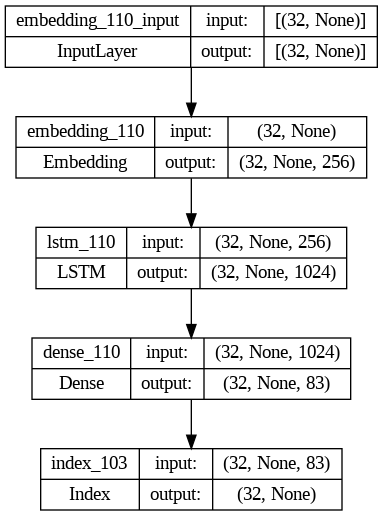

In [303]:
tf.keras.utils.plot_model(model, show_shapes=True)

Add an extra layer in the model which takes the input from the dense layer and returns index of sequence length.

In [304]:
model = build_model(len(vocab), 256, 1024, 10)
X, y = get_batch(vectorized_songs, 2, 10)
pred = model.predict(X)
print("Input shape:      ", X.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")
print(y)
print(pred)

ind:  Tensor("index_104/map/while/map/TensorArrayV2Stack/TensorListStack:0", shape=(None,), dtype=float32)
ind:  Tensor("sequential_111/index_104/map/while/map/TensorArrayV2Stack/TensorListStack:0", shape=(2,), dtype=float32)
1/1 [==============================] - 1s 610ms/step
Input shape:       (10, 2)  # (batch_size, sequence_length)
Prediction shape:  (10, 2) # (batch_size, sequence_length, vocab_size)
[[31. 14.]
 [59. 58.]
 [ 1. 32.]
 [21.  0.]
 [ 9. 78.]
 [27. 62.]
 [31. 26.]
 [ 9. 73.]
 [ 1. 32.]
 [44. 63.]]
[[49. 60.]
 [72. 37.]
 [15. 70.]
 [ 6. 51.]
 [60. 19.]
 [71. 28.]
 [81. 47.]
 [80. 75.]
 [18. 69.]
 [53. 39.]]


In [309]:
# print(X)
print(y.shape)
print(y)
print(pred.shape)
print(pred)
# for i in pred:
#   print(i.shape)
#   sampled_indices = tf.random.categorical(i, num_samples=1)
#   sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy
#   # sampled_indices.numpy

#   print(sampled_indices)

(10, 2)
[[31. 14.]
 [59. 58.]
 [ 1. 32.]
 [21.  0.]
 [ 9. 78.]
 [27. 62.]
 [31. 26.]
 [ 9. 73.]
 [ 1. 32.]
 [44. 63.]]
(10, 2)
[[49. 60.]
 [72. 37.]
 [15. 70.]
 [ 6. 51.]
 [60. 19.]
 [71. 28.]
 [81. 47.]
 [80. 75.]
 [18. 69.]
 [53. 39.]]


In [306]:
# print(X[0])
# print("Input: \n", repr("".join(index2char[list(map(int, X[0]))])))
# print()
# print("Next Char Predictions: \n", repr("".join(index2char[sampled_indices])))

In [316]:
pred = tf.reshape(pred, shape=[10,2])
loss = tf.keras.losses.sparse_categorical_crossentropy(
    y, pred, from_logits = True
)

print(loss.numpy().shape)

ValueError: ignored

Defining hyperparameters for training model.
- epochs: the number of iterations over whole data
- batch_size: the size of each minibatch i.e. the number of random indices from input
- learning_rate: learning rate or alpha

In [321]:
epochs = 2000
batch_size = 4
seq_length = 4
learning_rate = 1e-3

vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
print('Model built')
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics='sparse_categorical_accuracy',  # sparse_categorical_accuracy
              optimizer='Adam')

for i in range(1):
  x, y = get_batch(vectorized_songs, seq_length, batch_size)
  print(x)
  print(y)

  print(model.layers[0].output)
  print(model.layers[1].output)
  # model.fit(x, y, batch_size=batch_size)


res = model.predict(np.array([[68]]))
print(res)

ind:  Tensor("index_109/map/while/map/TensorArrayV2Stack/TensorListStack:0", shape=(None,), dtype=float32)
Model built
[[11. 20.  0. 36.]
 [61. 15. 59.  1.]
 [58. 59.  1. 60.]
 [59. 14. 27. 32.]]
[[20.  0. 36. 22.]
 [15. 59.  1. 62.]
 [59.  1. 60. 58.]
 [14. 27. 32.  1.]]
KerasTensor(type_spec=TensorSpec(shape=(4, None, 256), dtype=tf.float32, name=None), name='embedding_116/embedding_lookup/Identity_1:0', description="created by layer 'embedding_116'")
KerasTensor(type_spec=TensorSpec(shape=(4, None, 1024), dtype=tf.float32, name=None), name='lstm_116/PartitionedCall:1', description="created by layer 'lstm_116'")
ind:  Tensor("sequential_116/index_109/map/while/map/TensorArrayV2Stack/TensorListStack:0", shape=(1,), dtype=float32)
1/1 [==============================] - 1s 610ms/step
[[22.]
 [78.]
 [34.]
 [ 1.]]
